In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import itertools
import os

In [3]:
version = "2.0"
models = ["vit", "convnext", "xception"]
versions = ["1.4", "2.0", "2.1"]
other_versions = [v for v in versions if v.split('.')[0] != version.split('.')[0]]
#methods = ["", "_adversarial_rando", "_transforms_choice"]
methods = ["", "_adversarial_rando", "_transforms_choice", "_squeezed"]
method_to_name = {"": "baseline", "_adversarial_rando": "FastAT", "_transforms_choice": "data aug", "_squeezed": "squeezed"}
d = {}
for model, method in itertools.product(models, methods):
    file = f"{model}_{version}{method}_robustness.json"
    with open(file) as f:
        data = json.load(f)
        d[f"{model}: {method_to_name[method]}"] = data
    
    if method == "_squeezed":
        file = f"{model}_{version}_squeezed_square_partial_robustness.json"

        full_file = f"{model}_{version}_squeezed_square_robustness.json"
    
        if os.path.exists(full_file):
            file = full_file

        with open(file) as f:
            data = json.load(f)
            for key in data.keys():
                d[f"{model}: {method_to_name[method]}"][key] = data[key]

df = pd.DataFrame(d)
fields = [f"{version}_acc", "linf_0.01568627450980392_acc", "linf_0.03137254901960784_acc", "pad30_acc", "grayscale_acc", "randomaffine_acc", "compress_acc"] + [f"{v}_acc" for v in other_versions]
df = df.loc[fields]
df = df.transpose()
#df["method"] = [x.split("_")[1] for x in df.index.tolist()]
#df.index = [x.split("_")[0] for x in df.index.tolist()]
df.head()

,2.0_acc,linf_0.01568627450980392_acc,linf_0.03137254901960784_acc,pad30_acc,grayscale_acc,randomaffine_acc,compress_acc,1.4_acc
vit: baseline,90.41,5.62,0.79,63.64,77.18,77.73,90.38,87.07
vit: FastAT,87.59,64.075,43.02,61.855,73.11,78.69,87.48,82.83
vit: data aug,90.755,9.635,2.485,90.58,81.08,90.395,90.775,87.845
vit: squeezed,90.275,57.459677,30.997984,67.005,78.435,77.8,90.16,86.915
convnext: baseline,89.485,4.275,0.43,66.45,75.805,82.29,89.455,86.33


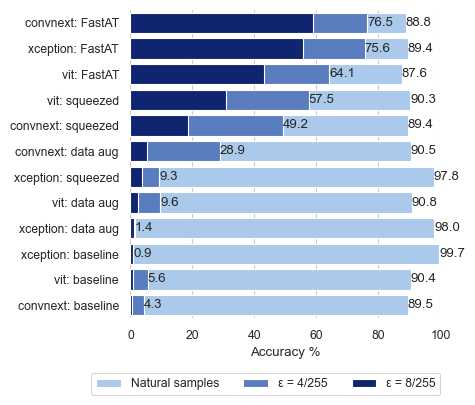

In [4]:
sns.set_theme(style="whitegrid", context="paper", palette="muted", font_scale=1.0)

f, ax = plt.subplots(figsize=(4, 4))
sns.set_color_codes("pastel")

df.sort_values(by=f"linf_0.03137254901960784_acc", inplace=True, ascending=False)

g = sns.barplot(x=f"{version}_acc", y=df.index, data=df,
            label="Natural samples", color="b")
# for i in g.containers:
#        g.bar_label(i,label_type='edge', fmt='%.1f')

sns.set_color_codes("muted")
g = sns.barplot(x="linf_0.01568627450980392_acc", y=df.index, data=df,
            label="ε = 4/255", color="b")
for i in g.containers:
       g.bar_label(i,label_type='edge', fmt='%.1f')

sns.set_color_codes("dark")
g = sns.barplot(x="linf_0.03137254901960784_acc", y=df.index, data=df,
            label="ε = 8/255", color="b")
# for idx, i in enumerate(g.containers):
#        if idx > 3:
#               break
#        print(idx)
#        g.bar_label(i,label_type='edge', fmt='%.1f')

ax.legend(ncol=3, loc="lower right", frameon=True, bbox_to_anchor=(1, -0.25), borderaxespad=0)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Accuracy %")
# ax.title.set_text(f"Accuracy of models trained on {version} dataset")
sns.despine(left=True, bottom=True)
plt.savefig(f"eps_{version}.png", bbox_inches='tight')


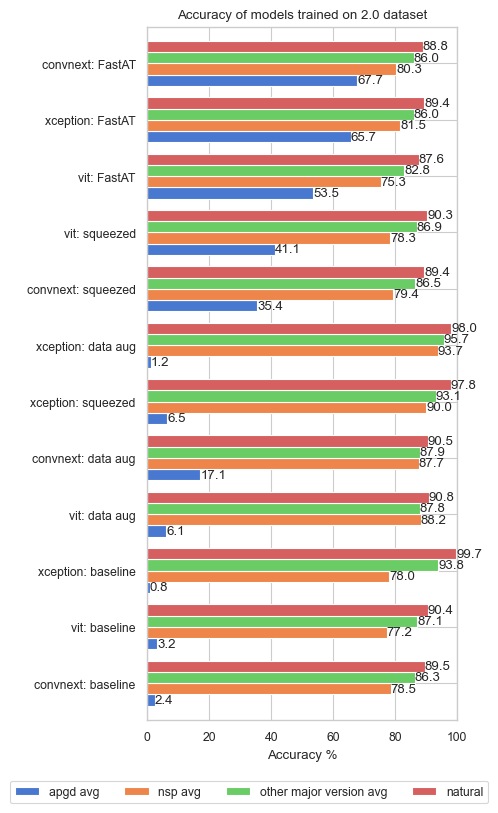

In [99]:
df2 = df.copy()
sns.set_theme(style="whitegrid", context="paper", palette="muted", font_scale=1.0)
df2["apgd avg"] = (df2["linf_0.01568627450980392_acc"] + df2["linf_0.03137254901960784_acc"]) / 2
df2["nsp avg"] = (df2["pad30_acc"] + df2["grayscale_acc"] + df2["randomaffine_acc"] + df2["compress_acc"]) / 4
df2["other major version avg"] = df2[[f"{v}_acc" for v in other_versions]].mean(axis=1)
df2.drop(columns=["linf_0.01568627450980392_acc", "linf_0.03137254901960784_acc"], inplace=True)
df2.drop(columns=["pad30_acc", "grayscale_acc", "randomaffine_acc", "compress_acc"], inplace=True)
df2.rename(columns={f"{version}_acc": "natural"}, inplace=True)

df2['mean'] = df2[['apgd avg', 'nsp avg', 'other major version avg', 'natural']].mean(axis=1)

df2.sort_values(by="mean", ascending=True, inplace=True)

ax = df2[['apgd avg', 'nsp avg', 'other major version avg', 'natural']].plot.barh(figsize=(4, 9), width=0.8)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="Accuracy %")
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.1f', label_type='edge')
ax.legend(ncol=4, loc="lower right", frameon=True, bbox_to_anchor=(1.1, -0.12), borderaxespad=0)
ax.title.set_text(f"Accuracy of models trained on {version} dataset")
plt.savefig(f"stacked_{version}.png", bbox_inches='tight')

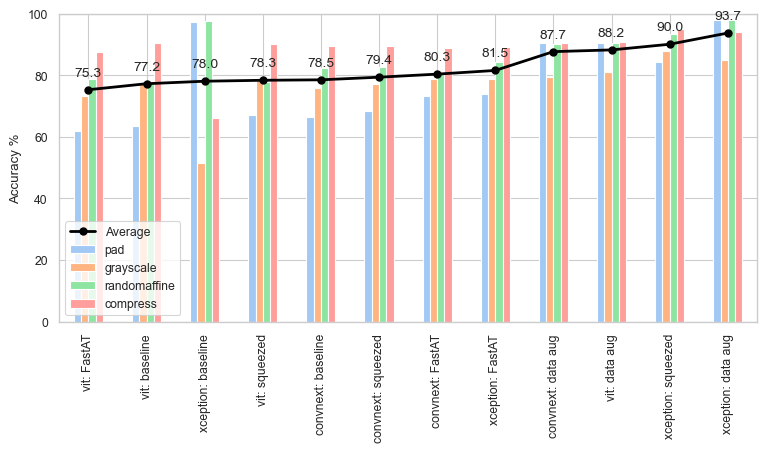

In [100]:
df3 = df.copy()
sns.set_theme(style="whitegrid", context="paper", palette="muted", font_scale=1.0)
df3.rename(columns={f"{version}_acc": "Natural samples"}, inplace=True)
df3.drop(columns=["Natural samples"], inplace=True)
df3.drop(columns=[f"{v}_acc" for v in other_versions], inplace=True)
df3.drop(columns=["linf_0.01568627450980392_acc", "linf_0.03137254901960784_acc"], inplace=True)
df3.rename(columns={"pad30_acc": "pad"}, inplace=True)
df3.rename(columns={"grayscale_acc": "grayscale"}, inplace=True)
df3.rename(columns={"randomaffine_acc": "randomaffine"}, inplace=True)
df3.rename(columns={"compress_acc": "compress"}, inplace=True)

df3['avg'] = df3.mean(axis=1)
df3.sort_values(by="avg", ascending=True, inplace=True)
ax = df3[['pad', 'grayscale', 'randomaffine', 'compress']].plot.bar(figsize=(9, 4), width=0.5, color=sns.palettes.SEABORN_PALETTES["pastel"][:4])
df3['avg'].plot(ax=ax, color="black", linewidth=2, label="Average", marker="o", markersize=5)

ax.set(ylim=(0, 100), ylabel="Accuracy %")
plt.xticks(rotation = 90)

for x,y in zip(ax.get_xticks(), df3['avg']):
    label = "{:.1f}".format(y)
    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels)
plt.savefig(f"nsp_perf_{version}.png", bbox_inches='tight')

In [101]:
ax.get_legend_handles_labels()

([<matplotlib.lines.Line2D at 0x1435ca980>,
  <BarContainer object of 12 artists>,
  <BarContainer object of 12 artists>,
  <BarContainer object of 12 artists>,
  <BarContainer object of 12 artists>],
 ['Average', 'pad', 'grayscale', 'randomaffine', 'compress'])